In [1]:
import pandas as pd
import numpy as np
import json
import datetime

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_rows = 200

sns.set_style('whitegrid')
plt.style.use('Cole_2018.mplstyle')

# 1. Load raw data

### 1a. Streaming history

In [2]:
json_path = '/gh/data/personal-data-requests/spotify/StreamingHistory.json'
df_history = pd.read_json(json_path)
df_history['dt'] = pd.to_datetime(df_history['endTime'])
df_history['date'] = df_history['dt'].dt.date
df_history['hour'] = df_history['dt'].dt.hour
df_history.drop('endTime', axis=1, inplace=True)
df_history.head()

,artistName,msPlayed,trackName,dt,date,hour
0,Semisonic,387937,Closing Time,2019-05-04 05:19:00,2019-05-04,5
1,Sheppard,218227,Geronimo,2019-05-04 05:23:00,2019-05-04,5
2,Simon & Garfunkel,244026,Mrs. Robinson,2019-05-04 05:27:00,2019-05-04,5
3,Skrillex,414746,Skrillex Orchestral Suite by Varien,2019-05-04 05:35:00,2019-05-04,5
4,Smallpools,6153,Dreaming,2019-05-04 15:45:00,2019-05-04,15


### 1b. Playlists

In [3]:
json_path = '/gh/data/personal-data-requests/spotify/Playlist.json'
with open(json_path) as json_file:
    data = json.load(json_file)
    
dfs = {}
for playlist in data['playlists']:
    dfs[playlist['name']] = pd.DataFrame([x['track'] for x in playlist['items']])
dfs['ScottDisc'].head()

,albumName,artistName,trackName
0,Young Love,Kye Kye,Broke
1,You're Going To Make It,Mates of State,Staring Contest
2,Weathervanes,Freelance Whales,Generator ^ First Floor
3,ADHDS,ADHDS,City
4,Absolution Calling,Incubus,Absolution Calling


### 1c. Library

In [4]:
json_path = '/gh/data/personal-data-requests/spotify/YourLibrary.json'
with open(json_path) as json_file:
    data = json.load(json_file)
df_library = pd.DataFrame(data['tracks'])
df_library.head()

,album,artist,track
0,We Are American Authors,American Authors,Believer
1,Boxer Live in Brussels,The National,Fake Empire (Live in Brussels)
2,The Man Who,Travis,Why Does It Always Rain on Me?
3,Smoke + Mirrors,Imagine Dragons,I Bet My Life
4,Day & Age,The Killers,Spaceman


### 1d. Search queries

In [5]:
json_path = '/gh/data/personal-data-requests/spotify/SearchQueries.json'
df_search = pd.read_json(json_path)
df_search.head()

,country,date,msDuration,platform,selectedQuery,terminationReason,typedQuery,userIntent,viewUri
0,US,2019-07-09,2161,IOS,None,INTERACTION,moby,navigate-forward,spotify:search
1,US,2019-07-09,0,DESKTOP,moby,INTERACTION,None,navigate-forward,spotify:search:moby
2,US,2019-07-23,0,DESKTOP,wilco,INTERACTION,None,navigate-forward,spotify:search:wilco
3,US,2019-07-23,0,DESKTOP,joy division,INTERACTION,None,navigate-forward,spotify:search:joy division
4,US,2019-07-24,0,DESKTOP,new order,INTERACTION,None,navigate-forward,spotify:search:new order


### 1e. follows

In [6]:
json_path = '/gh/data/personal-data-requests/spotify/Follow.json'
with open(json_path) as json_file:
    data = json.load(json_file)

artists_following = data['followingArtists']
artists_following

['Above & Beyond',
 'CHVRCHES',
 'Cigarettes After Sex',
 'Cold War Kids',
 'Death Cab for Cutie',
 'Driftless Pony Club',
 'Hank Green',
 'Helios',
 'Kettel',
 'Night Terrors of 1927',
 'The Airborne Toxic Event',
 'The Killers',
 'The National',
 'The Struts',
 'Twenty One Pilots']

# 2. Library stats

In [7]:
len(df_library)

303

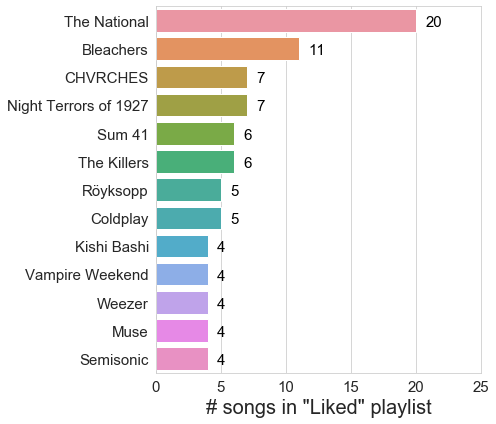

In [8]:
# Prep data to plot
n_songs_min = 4
df_plt = df_library['artist'].value_counts().reset_index().rename(columns={'index': 'artist', 'artist': 'count'})
df_plt = df_plt[df_plt['count'] >= n_songs_min]

# Plot bars
plt.figure(figsize=(7,6))
g=sns.barplot(x='count', y='artist', data=df_plt)

# Plot numbers
for index, row in df_plt.iterrows():
    g.text(x=row['count'] + .7,
           y=index + .2,
           s=row['count'],
           color='black',
           ha="left",
           size=15)

plt.ylabel('')
plt.xlabel('# songs in "Liked" playlist')
plt.xlim((0,25))
plt.tight_layout()
    
plt.savefig('/gh/srcole.github.io/assets/personaldata/spotify_liked_songs_artist_counts.png')

# 3. Streaming history

In [9]:
len(df_history)

7511

### 3a. Time series of  streaming

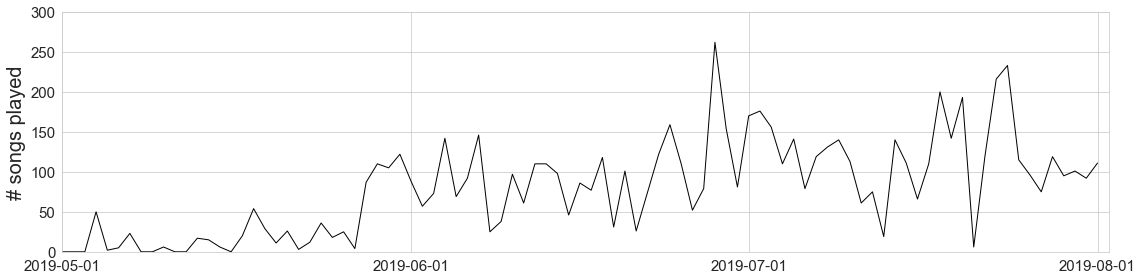

In [10]:
df_plt = df_history.groupby('date')['trackName'].count().reset_index()
df_plt = df_plt.set_index('date').reindex(pd.date_range('2019-05-01', '2019-08-01', freq='D')).fillna(0).reset_index().rename(columns={'index': 'date', 'trackName': 'count'})

plt.figure(figsize=(16,4))
sns.lineplot(x='date', y='count', data=df_plt, color='k', )
plt.xticks([datetime.datetime(2019, x, 1) for x in [5, 6, 7, 8]])
plt.xlim(datetime.datetime(2019, 5, 1), datetime.datetime(2019, 8, 2))
plt.ylim((0,300))
plt.xlabel('')
plt.ylabel('# songs played')
plt.tight_layout()
    
plt.savefig('/gh/srcole.github.io/assets/personaldata/spotify_play_count_by_day.png')

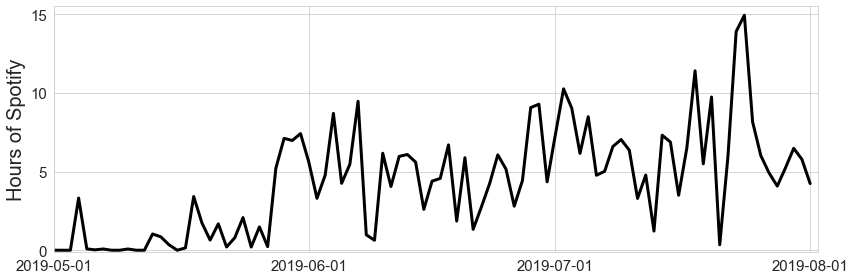

In [11]:
df_plt = df_history.groupby('date')['msPlayed'].sum().reset_index()
df_plt = df_plt.set_index('date').reindex(pd.date_range('2019-05-01', '2019-08-01', freq='D')).fillna(0).reset_index().rename(columns={'index': 'date', 'msPlayed': 'n_ms'})
df_plt['n_hours'] = df_plt['n_ms'] / (1000*60*60)

plt.figure(figsize=(12,4))
sns.lineplot(x='date', y='n_hours', data=df_plt, color='k', linewidth=3)
plt.xticks([datetime.datetime(2019, x, 1) for x in [5, 6, 7, 8]])
plt.xlim(datetime.datetime(2019, 5, 1), datetime.datetime(2019, 8, 2))
plt.ylim((-.1,15.5))
plt.yticks(np.arange(0,16,5))
plt.xlabel('')
plt.ylabel('Hours of Spotify')
plt.tight_layout()
    
plt.savefig('/gh/srcole.github.io/assets/personaldata/spotify_listening_duration_by_day.png')

### 3b. Top artists and songs

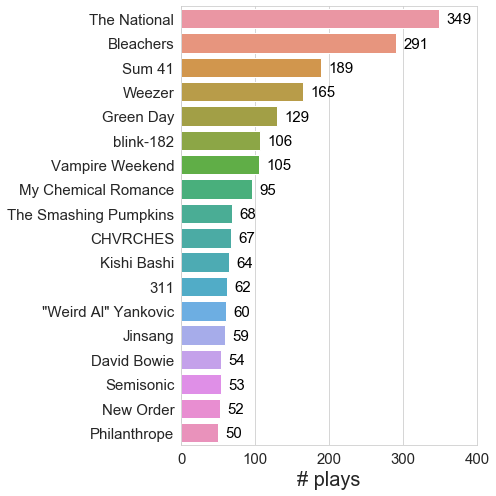

In [12]:
# Prep data to plot
n_songs_min = 50
df_plt = df_history['artistName'].value_counts().reset_index().rename(columns={'index': 'artist', 'artistName': 'count'})
df_plt = df_plt[df_plt['count'] >= n_songs_min]

# Plot bars
plt.figure(figsize=(7,7))
g=sns.barplot(x='count', y='artist', data=df_plt)

# Plot numbers
for index, row in df_plt.iterrows():
    g.text(x=row['count'] + 10,
           y=index + .2,
           s=row['count'],
           color='black',
           ha="left",
           size=15)

plt.ylabel('')
plt.xlabel('# plays')
plt.xlim((0,400))
plt.tight_layout()
    
plt.savefig('/gh/srcole.github.io/assets/personaldata/spotify_plays_artist_counts.png')

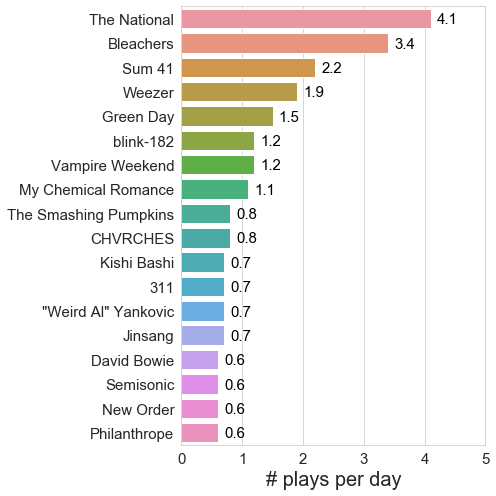

In [13]:
# Prep data to plot
n_songs_min = 50
df_plt = df_history['artistName'].value_counts().reset_index().rename(columns={'index': 'artist', 'artistName': 'count'})
df_plt = df_plt[df_plt['count'] >= n_songs_min]
n_days = df_history['date'].nunique()
df_plt['plays_per_day'] = (df_plt['count'] / n_days).round(1)

# Plot bars
plt.figure(figsize=(7,7))
g=sns.barplot(x='plays_per_day', y='artist', data=df_plt)

# Plot numbers
for index, row in df_plt.iterrows():
    g.text(x=row['plays_per_day'] + .1,
           y=index + .2,
           s=row['plays_per_day'],
           color='black',
           ha="left",
           size=15)

plt.ylabel('')
plt.xlabel('# plays per day')
plt.xlim((0,5))
plt.tight_layout()
    
plt.savefig('/gh/srcole.github.io/assets/personaldata/spotify_plays_per_day_artist_rank.png')

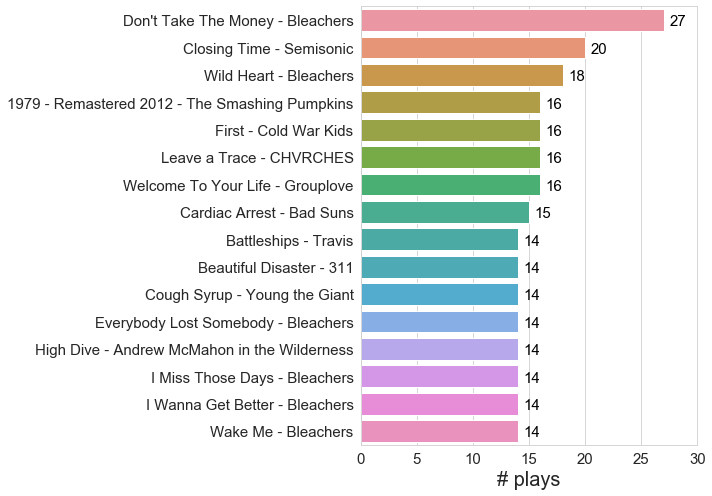

In [19]:
# Prep data to plot
n_songs_min = 14
df_plt = df_history.groupby(['trackName', 'artistName'])['msPlayed'].count().reset_index().rename(columns={'msPlayed': 'count'})
df_plt = df_plt[df_plt['count'] >= n_songs_min]
df_plt['song'] = ['{} - {}'.format(x,y) for (x,y) in zip(df_plt['trackName'], df_plt['artistName'])]
df_plt = df_plt.sort_values('count', ascending=False).reset_index(drop=True)

# Plot bars
plt.figure(figsize=(10,7))
g=sns.barplot(x='count', y='song', data=df_plt)

# Plot numbers
for index, row in df_plt.iterrows():
    g.text(x=row['count'] + .5,
           y=index + .2,
           s=row['count'],
           color='black',
           ha="left",
           size=15
          )

plt.ylabel('')
plt.xlabel('# plays')
plt.xlim((0,30))
plt.tight_layout()
    
plt.savefig('/gh/srcole.github.io/assets/personaldata/spotify_plays_top_songs.png')

### 3c. Compare bands over time

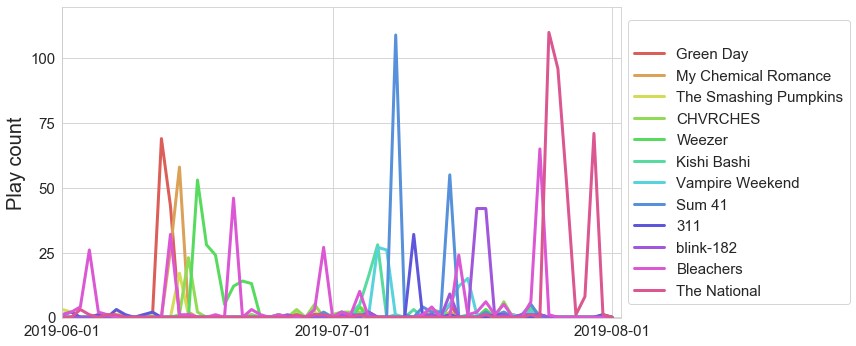

In [15]:
n_songs_min = 60
artist_counts = df_history['artistName'].value_counts()
artists_keep = artist_counts[artist_counts > n_songs_min].index
df_plt_pre = df_history[df_history['artistName'].isin(artists_keep)]

df_plt = df_plt_pre.groupby(['date', 'artistName'])['msPlayed'].count().reset_index()
df_plt = df_plt.pivot(index='date', columns='artistName', values='msPlayed').fillna(0)
df_plt = df_plt.reindex(pd.date_range('2019-05-01', '2019-08-01', freq='D')).fillna(0).stack().reset_index()
df_plt = df_plt.rename(columns={'level_0': 'date', 'artistName': 'artist', 0: 'count'})

# Compute hue order by peak
df_artists_maxs = df_plt.groupby(['artist'])['count'].max().reset_index()
df_artists_maxs = df_artists_maxs.merge(df_plt, on=['artist', 'count'], how='left')
artist_order = df_artists_maxs.drop_duplicates(subset=['artist', 'count']).sort_values('date')['artist']

plt.figure(figsize=(12,5))

# # overlay total count
# df_plt2 = df_history.groupby('date')['msPlayed'].count().reset_index()
# df_plt2 = df_plt2.set_index('date').reindex(pd.date_range('2019-05-01', '2019-08-01', freq='D')).fillna(0).reset_index().rename(columns={'index': 'date', 'msPlayed': 'count'})
# sns.lineplot(x='date', y='count', data=df_plt2, color='k', linewidth=3)

sns.lineplot(x='date', y='count', data=df_plt, hue='artist', linewidth=3,
             hue_order=artist_order,
             palette=sns.color_palette('hls', n_colors=len(artist_order))
            )
plt.xticks([datetime.datetime(2019, x, 1) for x in [5, 6, 7, 8]])
plt.xlim(datetime.datetime(2019, 6, 1), datetime.datetime(2019, 8, 2))
plt.ylim((-.2,120))
plt.yticks(np.arange(0,120,25))
plt.xlabel('')
plt.ylabel('Play count')

# Format legend
leg = plt.legend(fontsize=15, loc='center left', bbox_to_anchor=[1, .5])
leg.texts[0].set_text(None)
for line in leg.get_lines():
    line.set_linewidth(3)
plt.tight_layout()
    
plt.savefig('/gh/srcole.github.io/assets/personaldata/spotify_plays_by_band_temporal1.png')

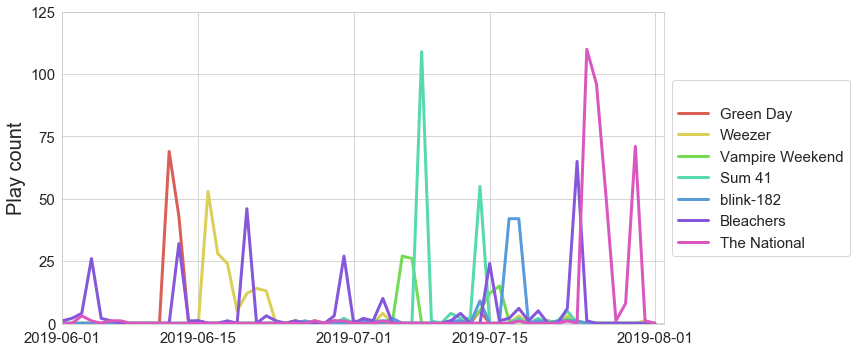

In [16]:
n_songs_min = 100
artist_counts = df_history['artistName'].value_counts()
artists_keep = artist_counts[artist_counts > n_songs_min].index
df_plt_pre = df_history[df_history['artistName'].isin(artists_keep)]

df_plt = df_plt_pre.groupby(['date', 'artistName'])['msPlayed'].count().reset_index()
df_plt = df_plt.pivot(index='date', columns='artistName', values='msPlayed').fillna(0)
df_plt = df_plt.reindex(pd.date_range('2019-05-01', '2019-08-01', freq='D')).fillna(0).stack().reset_index()
df_plt = df_plt.rename(columns={'level_0': 'date', 'artistName': 'artist', 0: 'count'})

# Compute hue order by peak
df_artists_maxs = df_plt.groupby(['artist'])['count'].max().reset_index()
df_artists_maxs = df_artists_maxs.merge(df_plt, on=['artist', 'count'], how='left')
artist_order = df_artists_maxs.drop_duplicates(subset=['artist', 'count']).sort_values('date')['artist']

plt.figure(figsize=(12,5))

# # overlay total count
# df_plt2 = df_history.groupby('date')['msPlayed'].count().reset_index()
# df_plt2 = df_plt2.set_index('date').reindex(pd.date_range('2019-05-01', '2019-08-01', freq='D')).fillna(0).reset_index().rename(columns={'index': 'date', 'msPlayed': 'count'})
# sns.lineplot(x='date', y='count', data=df_plt2, color='k', linewidth=3)

sns.lineplot(x='date', y='count', data=df_plt, hue='artist', linewidth=3,
             hue_order=artist_order,
             palette=sns.color_palette('hls', n_colors=len(artist_order))
            )
plt.xticks([datetime.datetime(2019, x, 1) for x in [6, 7, 8]] + [datetime.datetime(2019, x, 15) for x in [6, 7]])
plt.xlim(datetime.datetime(2019, 6, 1), datetime.datetime(2019, 8, 2))
plt.ylim((-.2,120))
plt.yticks(np.arange(0,130,25))
plt.xlabel('')
plt.ylabel('Play count')

# Format legend
leg = plt.legend(fontsize=15, loc='center left', bbox_to_anchor=[1, .5])
leg.texts[0].set_text(None)
for line in leg.get_lines():
    line.set_linewidth(3)
plt.tight_layout()
    
plt.savefig('/gh/srcole.github.io/assets/personaldata/spotify_plays_by_band_temporal2.png')